In [ ]:
import os, getpass
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

In [ ]:
load_dotenv(override=False)
host = os.getenv("PGHOST", "localhost")
port = int(os.getenv("PGPORT", "5432"))
db   = os.getenv("PGDATABASE", "mimic")
user = "postgres"
pwd  = os.getenv("PGPASSWORD") or getpass.getpass("PostgreSQL password: ")

engine = create_engine(f"postgresql+psycopg2://{user}:{pwd}@{host}:{port}/{db}", pool_pre_ping=True)

In [ ]:
engine = create_engine(
    f"postgresql+psycopg2://{user}:{pwd}@{host}:{port}/{db}",
    pool_pre_ping=True,
)

with engine.connect() as conn:
    schemas = conn.exec_driver_sql("""
        SELECT table_schema, table_name
        FROM information_schema.tables
        WHERE table_name IN ('admissions','patients','icustays')
          AND table_schema NOT IN ('pg_catalog','information_schema')
        ORDER BY table_schema, table_name;
    """).fetchall()

print("Candidate schemas with MIMIC tables:")
for s in schemas:
    print(s)

schema_env = None
if schemas:
    schema_env = schemas[0][0]
connect_args = {}
if schema_env:
    connect_args = {"options": f"-c search_path={schema_env},public"}

engine = create_engine(
    f"postgresql+psycopg2://{user}:{pwd}@{host}:{port}/{db}",
    pool_pre_ping=True,
    connect_args=connect_args,
)

with engine.connect() as conn:
    print("Connected to:", conn.exec_driver_sql("select version()").scalar())
    print("Using schema:", schema_env or "(default)")

In [ ]:
SCHEMA = schema_env or (schemas[0][0] if schemas else 'mimiciii')
admissions = f"{SCHEMA}.admissions"

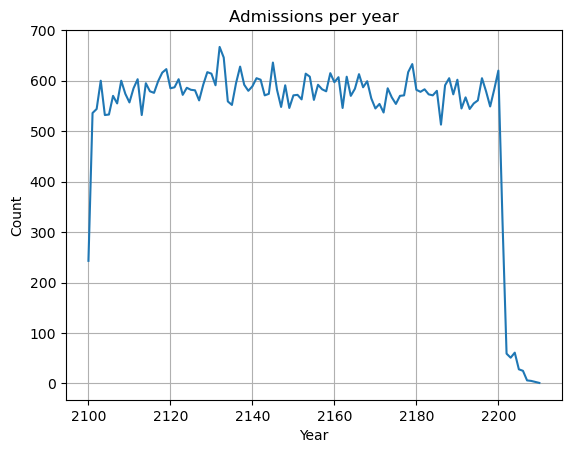

In [13]:
q_year = f"""
SELECT DATE_PART('year', admittime)::int AS year, COUNT(*)::bigint AS n
FROM admissions
WHERE admittime IS NOT NULL
GROUP BY 1
ORDER BY 1
"""
df_year = pd.read_sql_query(text(q_year), engine)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(df_year['year'], df_year['n'])
plt.title('Admissions per year')
plt.xlabel('Year'); plt.ylabel('Count'); plt.grid(True); plt.show()

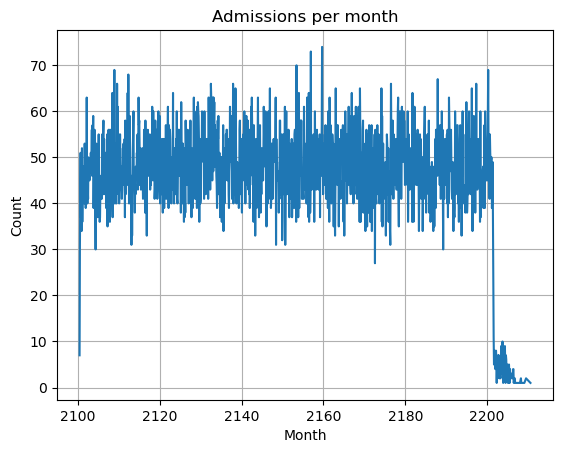

In [14]:
q_month = f"""
SELECT DATE_TRUNC('month', admittime) AS month, COUNT(*)::bigint AS n
FROM admissions
WHERE admittime IS NOT NULL
GROUP BY 1
ORDER BY 1
"""
df_month = pd.read_sql_query(text(q_month), engine)
df_month['month'] = pd.to_datetime(df_month['month'])

plt.figure()
plt.plot(df_month['month'], df_month['n'])
plt.title('Admissions per month')
plt.xlabel('Month'); plt.ylabel('Count'); plt.grid(True); plt.show()

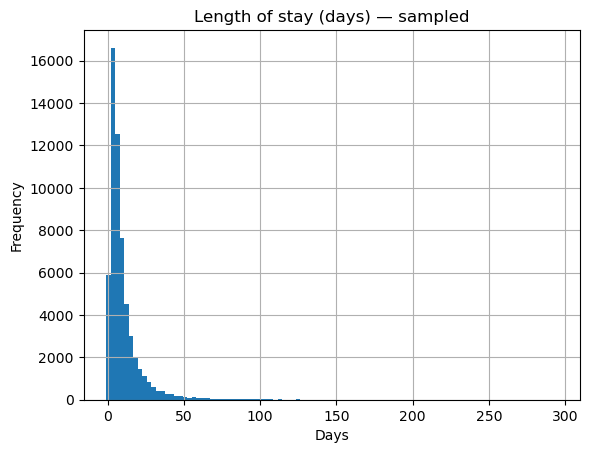

In [15]:
sample_n = int(os.getenv('MIMIC_LOS_SAMPLE', '200000'))
q_los = f"""
SELECT EXTRACT(EPOCH FROM (dischtime - admittime))/86400.0 AS los_days
FROM admissions
WHERE admittime IS NOT NULL AND dischtime IS NOT NULL
ORDER BY random()
LIMIT :n
"""
df_los = pd.read_sql_query(text(q_los), engine, params={'n': sample_n})

plt.figure()
plt.hist(df_los['los_days'].dropna(), bins=100)
plt.title('Length of stay (days) — sampled')
plt.xlabel('Days'); plt.ylabel('Frequency'); plt.grid(True); plt.show()